In [1]:
import numpy as np
import torch
import random
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from matplotlib.animation import FuncAnimation, FFMpegWriter

REL_POS_FOLLOWER1 = [-5, 5]
REL_POS_FOLLOWER2 = [-5, -5]


In [3]:
# 드론 클래스 정의
class Drone:
    def __init__(self, position, is_leader=False):
        self.position = np.array(position, dtype=np.float32)
        self.is_leader = is_leader
        self.orientation = np.array([0, 1, 0], dtype=np.float32)  # 초기 방향 (단위 벡터)

    def update_position(self, velocity):
        # 속도를 바탕으로 위치 업데이트
        self.position += velocity

    def get_relative_distance_and_direction(self, other_drone):
        # 다른 드론과의 상대적 거리와 방향 계산 (자신의 좌표계를 기준으로)
        relative_position = other_drone.position - self.position
        distance = np.linalg.norm(relative_position).astype(np.float32)

        # 방향 계산 (현재 드론의 좌표계를 기준으로)
        direction = relative_position / distance  # 정규화된 방향 벡터

        # 자신의 좌표계에서의 상대 방향을 얻기 위해 방향을 회전시킴
        relative_direction = np.dot(self._rotation_matrix(), direction).astype(np.float32)
        return distance, relative_direction

    def _rotation_matrix(self):
        # 2D 드론이라 가정하고, orientation을 기반으로 회전 행렬 생성
        angle = np.arctan2(self.orientation[1], self.orientation[0]).astype(np.float32)
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]], dtype=np.float32)
        return rotation_matrix

    def set_orientation(self, new_orientation):
        # 드론의 방향 업데이트
        self.orientation = np.array(new_orientation, dtype=np.float32) / np.linalg.norm(new_orientation)

In [4]:
# 환경 정의
class DroneFormationEnv(gym.Env):
    def __init__(self):
        super(DroneFormationEnv, self).__init__()
        self.leader = Drone([0.0, 0.0], is_leader=True)
        self.follower1 = Drone(REL_POS_FOLLOWER1)
        self.follower2 = Drone(REL_POS_FOLLOWER2)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)
        self.max_steps = 100
        self.current_step = 0
    
    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.leader.position = np.array([0.0, 0.0], dtype=np.float32)
        self.follower1.position = np.array(REL_POS_FOLLOWER1, dtype=np.float32)
        self.follower2.position = np.array(REL_POS_FOLLOWER2, dtype=np.float32)
        self.current_step = 0
        random_angle = random.uniform(-np.pi, np.pi)
        self.leader.orientation = np.array([np.cos(random_angle), np.sin(random_angle)], dtype=np.float32)
        self.leader_velocity = random.uniform(0.5, 5.0)
        
        # Return both the observation and an empty info dict
        return self._get_observation(), {}

    def _get_observation(self):
        distance1, direction1 = self.follower1.get_relative_distance_and_direction(self.leader)
        distance2, direction2 = self.follower2.get_relative_distance_and_direction(self.leader)
        return np.concatenate([[distance1], direction1, [distance2], direction2]).astype(np.float32)

    def step(self, action):
        velocity_f1 = action[:2]
        velocity_f2 = action[2:4]
        self.follower1.update_position(velocity_f1)
        self.follower2.update_position(velocity_f2)
        if self.current_step % 200 == 0:
            random_angle = random.uniform(-np.pi, np.pi)
            random_speed = random.uniform(0.5, 2.0)
            self.leader.orientation = np.array([np.cos(random_angle), np.sin(random_angle)], dtype=np.float32)
            self.leader_velocity = random_speed
        leader_velocity = self.leader.orientation * self.leader_velocity
        self.leader.update_position(leader_velocity)
        reward = float(self._compute_reward())
        terminated = self._check_done()
        self.current_step += 1
        truncated = self.current_step >= self.max_steps
        return self._get_observation(), reward, terminated, truncated, {}

    def _compute_reward(self):
        if self._check_collision() or self._check_drift():
            return -100
        original_target_follower1 = np.array(REL_POS_FOLLOWER1, dtype=np.float32)
        original_target_follower2 = np.array(REL_POS_FOLLOWER2, dtype=np.float32)
        rotation_matrix = self.leader._rotation_matrix()
        rotated_target_follower1 = np.dot(rotation_matrix, original_target_follower1)
        rotated_target_follower2 = np.dot(rotation_matrix, original_target_follower2)
        global_target_follower1 = self.leader.position + rotated_target_follower1
        global_target_follower2 = self.leader.position + rotated_target_follower2
        distance_follower1 = np.linalg.norm(self.follower1.position - global_target_follower1)
        distance_follower2 = np.linalg.norm(self.follower2.position - global_target_follower2)
        return - (distance_follower1 + distance_follower2)

    def _check_collision(self):
        distance_between_leader_and_follower1 = np.linalg.norm(self.leader.position - self.follower1.position)
        distance_between_leader_and_follower2 = np.linalg.norm(self.leader.position - self.follower2.position)
        distance_between_followers = np.linalg.norm(self.follower1.position - self.follower2.position)
        if distance_between_followers < 2 or distance_between_leader_and_follower1 < 2 or distance_between_leader_and_follower2 < 2:
            return True
        else:
            return False
    
    def _check_drift(self):
        distance_between_leader_and_follower1 = np.linalg.norm(self.leader.position - self.follower1.position)
        distance_between_leader_and_follower2 = np.linalg.norm(self.leader.position - self.follower2.position)

        if distance_between_leader_and_follower2 > 10 or distance_between_leader_and_follower1 > 10:
            return True
        else:
            return False


    def _check_done(self):
        return self._check_collision() or self._check_drift()


# CUDA 지원 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 환경 생성
env = DroneFormationEnv()

# 환경이 올바르게 정의되었는지 확인
check_env(env)

Using device: cuda


In [6]:
# PPO 모델 학습
model = PPO("MlpPolicy", env, verbose=1, device=device)
model.learn(total_timesteps=50000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.88     |
|    ep_rew_mean     | -170     |
| time/              |          |
|    fps             | 626      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 4.75          |
|    ep_rew_mean          | -164          |
| time/                   |               |
|    fps                  | 556           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.004282701   |
|    clip_fraction        | 0.0314        |
|    clip_range           | 0.2      

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

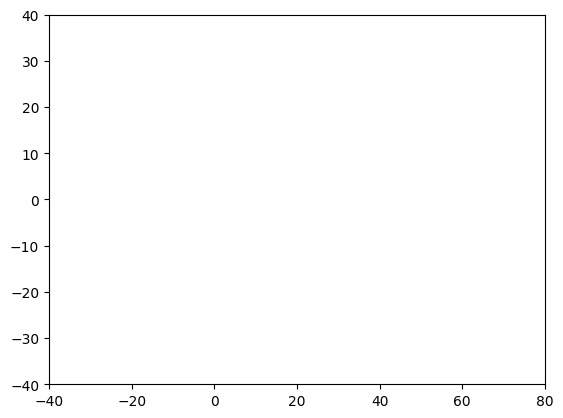

In [7]:
# GUI용 matplotlib 설정
fig, ax = plt.subplots()
ax.set_xlim(-40, 80)
ax.set_ylim(-40, 40)
writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)

leader_point, = ax.plot([], [], 'ro', label='Leader')  # 리더 드론은 빨간색
follower1_point, = ax.plot([], [], 'bo', label='Follower 1')  # 팔로워 1 드론은 파란색
follower2_point, = ax.plot([], [], 'go', label='Follower 2')  # 팔로워 2 드론은 초록색

# 초기화 함수
def init():
    leader_point.set_data([], [])
    follower1_point.set_data([], [])
    follower2_point.set_data([], [])
    return leader_point, follower1_point, follower2_point

# 애니메이션 업데이트 함수
obs, _ = env.reset()

def update(frame):
    global obs
    action, _states = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, _ = env.step(action)
    
    leader_point.set_data([env.leader.position[0]], [env.leader.position[1]])
    follower1_point.set_data([env.follower1.position[0]], [env.follower1.position[1]])
    follower2_point.set_data([env.follower2.position[0]], [env.follower2.position[1]])

    if terminated or truncated:
        obs, _ = env.reset()

    return leader_point, follower1_point, follower2_point

# 애니메이션 실행
ani = FuncAnimation(fig, update, frames=np.arange(0, 100), init_func=init, blit=True, repeat=False)

# mp4 파일로 저장
ani.save("drone_animation.mp4", writer=writer)
